In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import h5py
import time

In [2]:
def MomentumModulus(px, py, pz):
    return np.sqrt(px**2 + py**2 + pz**2)

def TransverseMomentumModulus(px, py):
    return np.sqrt(px**2 + py**2)

In [3]:
inputMC = 'data/LHCbMC_2016-2017-2018_MagUpDown_Lb2JPsiL_Ttracks_v12.h5'

tickMC = time.perf_counter()
df_reco = pd.read_hdf(inputMC, key='LHCbMC_Lb')
tockMC = time.perf_counter()
print(f"Monte Carlo imported in {tockMC - tickMC:0.4f} seconds.")

tickMCTruth = time.perf_counter()
df_truth = pd.read_hdf(inputMC, key='LHCbMCTruth_Lb')
tockMCTruth = time.perf_counter()
print(f"Monte Carlo Truth imported in {tockMCTruth - tickMCTruth:0.4f} seconds.")

tickMerge = time.perf_counter()
df_MC = pd.merge(df_truth.loc[df_truth['Rec_key'] >= 0], df_reco, left_index=True, right_on='MC_key')
tockMerge = time.perf_counter()
print(f"Monte Carlo merged in {tockMerge - tickMerge:0.4f} seconds.")
df_MC = df_MC.loc[(df_MC['MC_key'] >= 0) & (df_MC['Rec_key'] >= 0)]

Monte Carlo imported in 2.4075 seconds.
Monte Carlo Truth imported in 23.7742 seconds.
Monte Carlo merged in 2.4735 seconds.


In [4]:
JPsi1SPDGMass = 3096.900

PionPCuts = (MomentumModulus(df_MC['pim_PX'], df_MC['pim_PY'], df_MC['pim_PZ']) > 2000) & (MomentumModulus(df_MC['pim_PX'], df_MC['pim_PY'], df_MC['pim_PZ']) < 5e5)
ProtonPCuts = (MomentumModulus(df_MC['p_PX'], df_MC['p_PY'], df_MC['p_PZ']) > 10000) & (MomentumModulus(df_MC['p_PX'], df_MC['p_PY'], df_MC['p_PZ']) < 5e5)
ProtonPTCuts = TransverseMomentumModulus(df_MC['p_PX'], df_MC['p_PY']) > 400
## Combined m(p-pi)? Seems to be "AM" in the DaVinci opt file
LambdaMCuts = (df_MC['L_M'] > 600) & (df_MC['L_M'] < 1500)
LambdaMMCuts = df_MC['L_MM'] < 1500
LambdaZCuts = (df_MC['L_ENDVERTEX_Z'] > 5500) & (df_MC['L_ENDVERTEX_Z'] < 8500)
LambdaDiraCuts = (df_MC['L_BPVDIRA'] > 0.9999)
LambdaBPVIPCHI2Cuts = df_MC['L_BPVIPCHI2'] < 200
LambdaBPVVDCHI2Cuts = df_MC['L_BPVVDCHI2'] < 2e7
LambdaChi2Cuts = df_MC['L_VFASPF_CHI2_VDOF'] < 750
JPsiMCuts = df_MC['Jpsi_M'] - JPsi1SPDGMass < 90
LambdaPTCuts = TransverseMomentumModulus(df_MC['L_PX'], df_MC['L_PY']) > 450
## Combined m(JpsiLambda)? See comment above
LambdabMCuts = (df_MC['Lb_M'] < 8500)
LambdabDiraCuts = abs(df_MC['Lb_BPVDIRA']) > 0.99
LambdabBPVIPCHI2Cuts = df_MC['Lb_BPVIPCHI2'] < 1750
LambdabChi2Cuts = df_MC['Lb_VFASPF_CHI2_VDOF'] < 150

DTFCuts = df_MC['DTF_FixJPsiLambda_status'] == 'Success'

df_MC_Filtered = df_MC.loc[
    PionPCuts &
    ProtonPCuts &
    ProtonPTCuts &
    LambdaMCuts &
    LambdaMMCuts &
    LambdaZCuts &
    LambdaDiraCuts &
    LambdaBPVIPCHI2Cuts &
    LambdaBPVVDCHI2Cuts &
    LambdaChi2Cuts &
    JPsiMCuts &
    LambdaPTCuts &
    LambdabMCuts &
    LambdabDiraCuts &
    LambdabBPVIPCHI2Cuts &
    LambdabChi2Cuts &
    DTFCuts
]

df_MC_Filtered

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,DTF_FixJPsiLambda_PIDSubs_p_PY,DTF_FixJPsiLambda_PIDSubs_p_PZ,DTF_FixJPsiLambda_PIDSubs_mum_PX,DTF_FixJPsiLambda_PIDSubs_mum_PY,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ,TrackType_y,MC_key
Rec_key,,,,,,,,,,,,,,,,,,,,,
1,0.8237,-0.2123,3.514200,140.238602,325.837311,7463.102539,367.250000,1035.959961,24602.169922,174.279999,...,222.666214,4137.976074,-605.608093,594.454895,11170.495117,71.893692,-2873.631348,73489.484375,T,29
14,0.9904,-0.2075,-9.769600,224.561996,56.081600,5921.048828,2894.560059,699.140015,74302.851562,293.929993,...,104.645416,10220.954102,-884.967468,195.843964,34903.839844,1645.699585,-1113.117432,24484.212891,T,367
17,0.8236,-0.2738,28.986401,-296.374695,-100.123802,5963.561523,-1268.760010,-522.340027,25478.310547,-184.460007,...,20.153040,3543.737305,-829.315674,-926.117676,37815.328125,2614.833252,-1553.520630,63936.839844,T,493
22,0.7534,-0.2931,-1.211400,-38.645302,-105.471802,7776.826172,-649.429993,-1605.150024,113660.250000,-26.830000,...,-212.451355,21583.396484,-1120.001343,617.919861,42654.800781,-1715.901855,-2823.659180,61855.921875,T,557
23,0.6816,-0.1256,-69.357803,-842.685730,554.711914,4903.516602,-4999.830078,3343.699951,29197.720703,-1027.900024,...,608.672302,6324.328125,-4228.179688,1785.341675,18403.882812,-106.489746,-762.340759,4744.328613,T,572
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
366327,0.1985,-0.1576,-19.471500,-207.092300,-37.506302,6777.450195,-2266.669922,-458.640015,76301.921875,-294.079987,...,11.039152,7001.399414,-21.106155,590.822510,6469.677734,-4038.527100,-3013.788818,66493.257812,T,8920122
366331,0.8633,0.1466,-68.771400,-63.068901,-245.641098,6745.173828,-477.579987,-2102.550049,59762.968750,-199.369995,...,-527.474792,12987.607422,-1450.088257,-2851.202637,36621.058594,-248.967667,760.289551,5327.538574,T,8920230
366333,1.1884,-0.0951,69.203400,111.651604,74.976997,6779.822754,1028.930054,635.940002,62082.968750,293.480011,...,359.789764,23482.865234,860.183899,-878.939331,13367.183594,371.847900,-2149.595215,118211.546875,T,8920398


# The Bump
This notebook is dedicated to the study of the following "bump" of events in the $\Lambda$ decay vertex $\Delta z := z - z^\text{true}$ distribution.

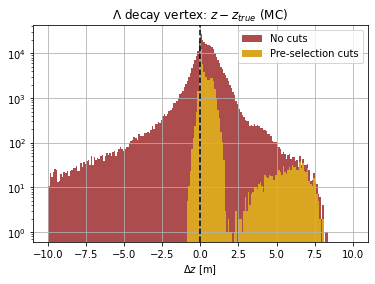

In [5]:
plt.hist((df_MC['L_ENDVERTEX_Z'] - df_MC['MCTRUTH_L_ENDVERTEX_Z'])/1000,
         range=(-10,10), bins=200, color='darkred',alpha=0.7, label='No cuts')
plt.hist((df_MC_Filtered['L_ENDVERTEX_Z'] - df_MC_Filtered['MCTRUTH_L_ENDVERTEX_Z'])/1000,
         range=(-10,10), bins=200, color='goldenrod', label='Pre-selection cuts')
plt.axvline(0,0,100,color='k', linestyle='--')
plt.grid()
plt.yscale('log')
plt.title('$\Lambda$ decay vertex: $z-z_{true}$ (MC)')
plt.xlabel('$\Delta z$ [m]')
plt.legend()
#plt.savefig("plots/lambda_endvertex/LEVz_MC_true-residuals.pdf", bbox_inches = "tight")
plt.show()

They are not as impactful as they might seem (log scale means the bump only comes from a little over 1300 events), but still worth a study to try and understand where they come from.

In [6]:
bumpMin = 2500
bumpMax = max(df_MC['L_ENDVERTEX_Z'] - df_MC['MCTRUTH_L_ENDVERTEX_Z'])

df_MC_Bump = df_MC_Filtered.loc[(df_MC['L_ENDVERTEX_Z'] - df_MC['MCTRUTH_L_ENDVERTEX_Z'] > bumpMin) 
                                & (df_MC['L_ENDVERTEX_Z'] - df_MC['MCTRUTH_L_ENDVERTEX_Z'] < bumpMax)]
df_MC_Bump

,MCTRUTH_Lb_ENDVERTEX_X,MCTRUTH_Lb_ENDVERTEX_Y,MCTRUTH_Lb_ENDVERTEX_Z,MCTRUTH_L_ENDVERTEX_X,MCTRUTH_L_ENDVERTEX_Y,MCTRUTH_L_ENDVERTEX_Z,MCTRUTH_p_PX,MCTRUTH_p_PY,MCTRUTH_p_PZ,MCTRUTH_pim_PX,...,DTF_FixJPsiLambda_PIDSubs_p_PY,DTF_FixJPsiLambda_PIDSubs_p_PZ,DTF_FixJPsiLambda_PIDSubs_mum_PX,DTF_FixJPsiLambda_PIDSubs_mum_PY,DTF_FixJPsiLambda_PIDSubs_mum_PZ,DTF_FixJPsiLambda_PIDSubs_mup_PX,DTF_FixJPsiLambda_PIDSubs_mup_PY,DTF_FixJPsiLambda_PIDSubs_mup_PZ,TrackType_y,MC_key
Rec_key,,,,,,,,,,,,,,,,,,,,,
83,0.3591,0.5208,54.601398,-7.069900,3.450100,207.821304,-2133.159912,839.080017,47703.500000,-462.730011,...,168.644516,8050.427246,-877.465881,2949.704102,28659.386719,503.071472,542.181152,34615.269531,T,2161
322,0.9811,-0.1064,-10.373100,39.110401,-9.633700,892.385681,2256.040039,-580.280029,53323.429688,373.010010,...,11.394564,9777.557617,245.647934,-661.962646,6534.991699,214.789459,2318.685303,79123.320312,T,7154
481,1.8740,-0.5979,-7.037500,77.090500,9.801200,2603.591553,2191.830078,419.899994,75441.242188,326.279999,...,105.792328,10330.285156,4723.738770,-1085.751831,94738.843750,4505.037598,-4013.477539,156311.734375,T,10886
1321,-0.0331,0.4286,-29.150000,-23.548599,19.783300,1213.161255,-1286.079956,1014.260010,59612.480469,-243.539993,...,375.111206,19825.923828,-2780.458984,1261.912231,29981.962891,693.816040,-195.606369,12767.225586,T,32475
1444,0.8146,0.1001,4.649700,-14.686500,163.640793,2154.786377,-396.440002,3648.179932,48638.878906,-54.220001,...,1180.691772,16734.375000,-254.849716,2805.153809,18249.675781,-387.394989,-649.787659,12084.038086,T,35581
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
363254,0.9424,0.1122,100.497597,33.673599,-5.969800,955.560913,2843.709961,-513.719971,68709.562500,351.579987,...,-84.022301,11739.583008,-444.325073,736.471130,6150.835938,1683.664185,-1841.182007,35031.601562,T,8846175
364456,0.9301,0.1707,7.379400,76.163399,34.881001,1255.683228,2559.040039,1106.670044,42477.660156,227.399994,...,184.448959,5276.213379,-882.276062,-382.208893,4555.773926,2310.619873,-96.750633,21770.988281,T,8875352
365169,1.1743,-0.4532,-50.668201,36.172401,-199.167999,2680.486816,493.239990,-2741.459961,36542.378906,226.919998,...,-749.432617,9753.463867,2238.845947,-1381.431030,22076.921875,-561.357300,431.169312,16543.582031,T,8892312


## Distribution and dependence on $z$

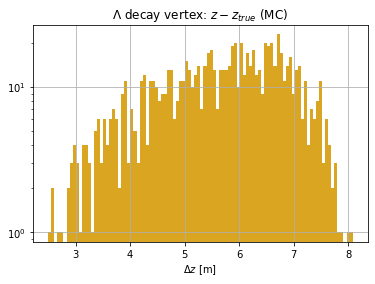

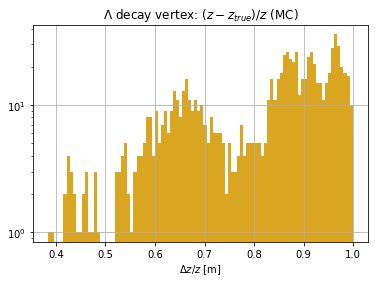

In [7]:
plt.hist((df_MC_Bump['L_ENDVERTEX_Z'] - df_MC_Bump['MCTRUTH_L_ENDVERTEX_Z'])/1000,
         bins=100, color='goldenrod', label='Pre-selection cuts')
plt.grid()
plt.yscale('log')
plt.title('$\Lambda$ decay vertex: $z-z_{true}$ (MC)')
plt.xlabel('$\Delta z$ [m]')
#plt.legend()
plt.show()

plt.hist((df_MC_Bump['L_ENDVERTEX_Z'] - df_MC_Bump['MCTRUTH_L_ENDVERTEX_Z'])/df_MC_Bump['L_ENDVERTEX_Z'],
         bins=100, color='goldenrod', label='Pre-selection cuts')
plt.grid()
plt.yscale('log')
plt.title('$\Lambda$ decay vertex: $(z-z_{true})/z$ (MC)')
plt.xlabel('$\Delta z / z$ [m]')
#plt.legend()
plt.show()

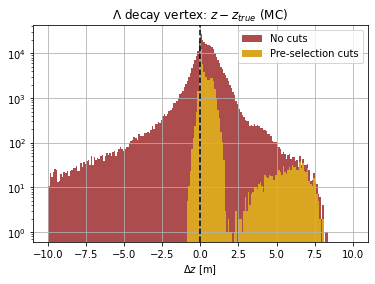

In [8]:
plt.hist((df_MC['L_ENDVERTEX_Z'] - df_MC['MCTRUTH_L_ENDVERTEX_Z'])/1000,
         range=(-10,10), bins=200, color='darkred',alpha=0.7, label='No cuts')
plt.hist((df_MC_Filtered['L_ENDVERTEX_Z'] - df_MC_Filtered['MCTRUTH_L_ENDVERTEX_Z'])/1000,
         range=(-10,10), bins=200, color='goldenrod', label='Pre-selection cuts')
plt.axvline(0,0,100,color='k', linestyle='--')
plt.grid()
plt.yscale('log')
plt.title('$\Lambda$ decay vertex: $z-z_{true}$ (MC)')
plt.xlabel('$\Delta z$ [m]')
plt.legend()
plt.savefig("plots/lambda_endvertex/LEVz_MC_true-residuals.pdf", bbox_inches = "tight")
plt.show()

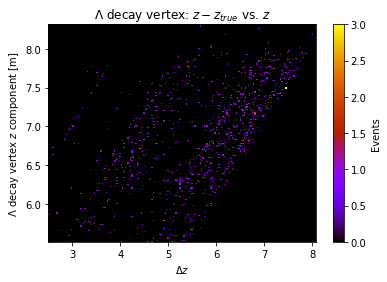

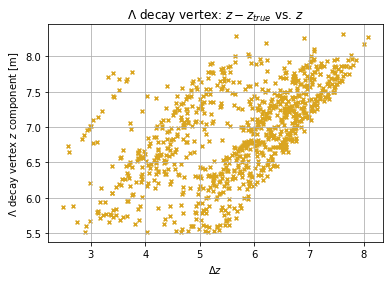

In [9]:
plt.hist2d((df_MC_Bump['L_ENDVERTEX_Z'] - df_MC_Bump['MCTRUTH_L_ENDVERTEX_Z'])/1000,
           df_MC_Bump['L_ENDVERTEX_Z']/1000,
           bins=200, cmap='gnuplot')
plt.xlabel('$\Delta z$')
plt.ylabel("$\Lambda$ decay vertex $z$ component [m]")
plt.title('$\Lambda$ decay vertex: $z-z_{true}$ vs. $z$')
plt.colorbar(label='Events')
plt.show()

plt.scatter((df_MC_Bump['L_ENDVERTEX_Z'] - df_MC_Bump['MCTRUTH_L_ENDVERTEX_Z'])/1000,
           df_MC_Bump['L_ENDVERTEX_Z']/1000,
           marker='x', s=15, color='goldenrod')
plt.xlabel('$\Delta z$')
plt.ylabel("$\Lambda$ decay vertex $z$ component [m]")
plt.title('$\Lambda$ decay vertex: $z-z_{true}$ vs. $z$')
plt.grid()
plt.show()

Visible substructures of $\Delta z$ as a function of $z$. While one can expect a general $z - z^\text{true} \propto z$ dependence, it would seem that the Bump is triggered by specific values of $z^\text{true}$ (i.e. specific vertical intercepts).

By contrast, here is how the same plots look when all filtered events are taken into account.

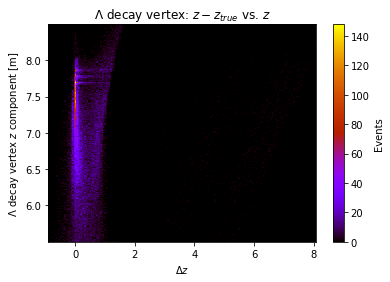

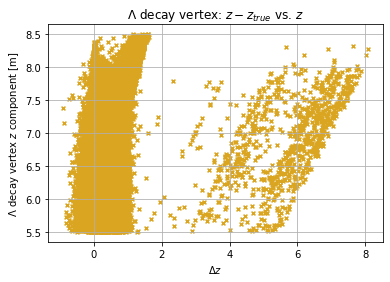

In [10]:
plt.hist2d((df_MC_Filtered['L_ENDVERTEX_Z'] - df_MC_Filtered['MCTRUTH_L_ENDVERTEX_Z'])/1000,
           df_MC_Filtered['L_ENDVERTEX_Z']/1000,
           bins=200, cmap='gnuplot')
plt.xlabel('$\Delta z$')
plt.ylabel("$\Lambda$ decay vertex $z$ component [m]")
plt.title('$\Lambda$ decay vertex: $z-z_{true}$ vs. $z$')
plt.colorbar(label='Events')
plt.show()

plt.scatter((df_MC_Filtered['L_ENDVERTEX_Z'] - df_MC_Filtered['MCTRUTH_L_ENDVERTEX_Z'])/1000,
           df_MC_Filtered['L_ENDVERTEX_Z']/1000,
           marker='x', s=15, color='goldenrod')
plt.xlabel('$\Delta z$')
plt.ylabel("$\Lambda$ decay vertex $z$ component [m]")
plt.title('$\Lambda$ decay vertex: $z-z_{true}$ vs. $z$')
plt.grid()
plt.show()

(Squint your eyes a little, the lines are still there in the 2D histogram. They're just very faint.)

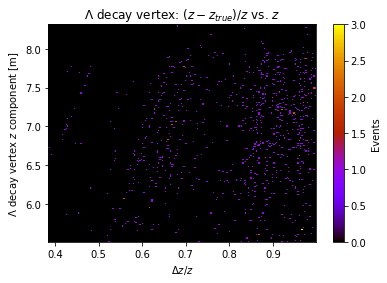

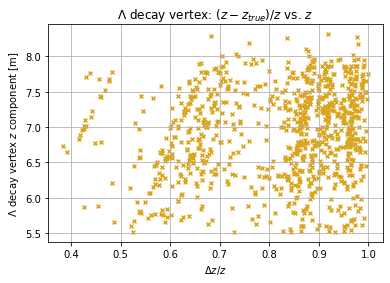

In [11]:
plt.hist2d((df_MC_Bump['L_ENDVERTEX_Z'] - df_MC_Bump['MCTRUTH_L_ENDVERTEX_Z'])/df_MC_Bump['L_ENDVERTEX_Z'],
           df_MC_Bump['L_ENDVERTEX_Z']/1000,
           bins=200, cmap='gnuplot')
plt.xlabel('$\Delta z / z$')
plt.ylabel("$\Lambda$ decay vertex $z$ component [m]")
plt.title('$\Lambda$ decay vertex: $(z-z_{true})/z$ vs. $z$')
plt.colorbar(label='Events')
plt.show()

plt.scatter((df_MC_Bump['L_ENDVERTEX_Z'] - df_MC_Bump['MCTRUTH_L_ENDVERTEX_Z'])/df_MC_Bump['L_ENDVERTEX_Z'],
           df_MC_Bump['L_ENDVERTEX_Z']/1000,
           marker='x', s=15, color='goldenrod')
plt.xlabel('$\Delta z / z$')
plt.ylabel("$\Lambda$ decay vertex $z$ component [m]")
plt.title('$\Lambda$ decay vertex: $(z-z_{true})/z$ vs. $z$')
plt.grid()
plt.show()

## Event distribution in the detector
### As reconstructed

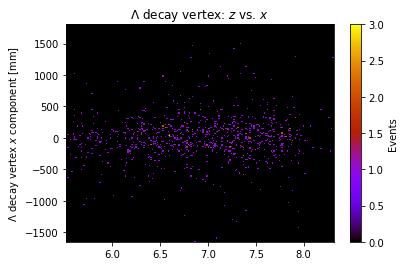

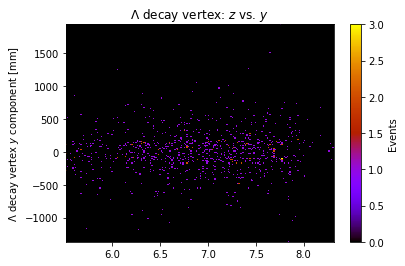

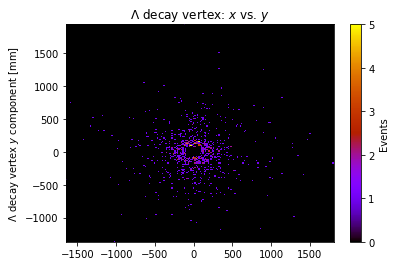

In [12]:
plt.hist2d(df_MC_Bump['L_ENDVERTEX_Z']/1000, df_MC_Bump['L_ENDVERTEX_X'],
           bins=200, cmap='gnuplot')
plt.ylabel("$\Lambda$ decay vertex $z$ component [m]")
plt.ylabel("$\Lambda$ decay vertex $x$ component [mm]")
plt.title('$\Lambda$ decay vertex: $z$ vs. $x$')
plt.colorbar(label='Events')
plt.show()

plt.hist2d(df_MC_Bump['L_ENDVERTEX_Z']/1000, df_MC_Bump['L_ENDVERTEX_Y'],
           bins=200, cmap='gnuplot')
plt.ylabel("$\Lambda$ decay vertex $z$ component [m]")
plt.ylabel("$\Lambda$ decay vertex $y$ component [mm]")
plt.title('$\Lambda$ decay vertex: $z$ vs. $y$')
plt.colorbar(label='Events')
plt.show()

plt.hist2d(df_MC_Bump['L_ENDVERTEX_X'], df_MC_Bump['L_ENDVERTEX_Y'],
           bins=200, cmap='gnuplot')
plt.ylabel("$\Lambda$ decay vertex $x$ component [mm]")
plt.ylabel("$\Lambda$ decay vertex $y$ component [mm]")
plt.title('$\Lambda$ decay vertex: $x$ vs. $y$')
plt.colorbar(label='Events')
plt.show()

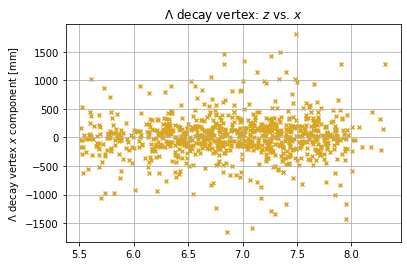

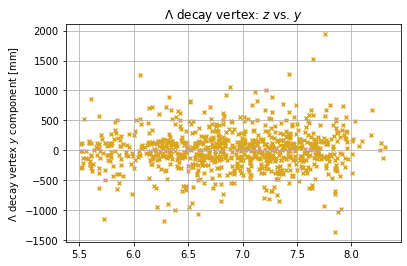

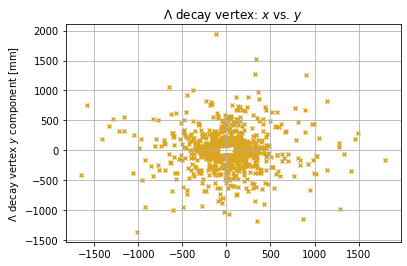

In [13]:
plt.scatter(df_MC_Bump['L_ENDVERTEX_Z']/1000, df_MC_Bump['L_ENDVERTEX_X'],
           marker='x', s=15, color='goldenrod')
plt.ylabel("$\Lambda$ decay vertex $z$ component [m]")
plt.ylabel("$\Lambda$ decay vertex $x$ component [mm]")
plt.title('$\Lambda$ decay vertex: $z$ vs. $x$')
plt.grid()
plt.show()

plt.scatter(df_MC_Bump['L_ENDVERTEX_Z']/1000, df_MC_Bump['L_ENDVERTEX_Y'],
           marker='x', s=15, color='goldenrod')
plt.ylabel("$\Lambda$ decay vertex $z$ component [m]")
plt.ylabel("$\Lambda$ decay vertex $y$ component [mm]")
plt.title('$\Lambda$ decay vertex: $z$ vs. $y$')
plt.grid()
plt.show()

plt.scatter(df_MC_Bump['L_ENDVERTEX_X'], df_MC_Bump['L_ENDVERTEX_Y'],
           marker='x', s=15, color='goldenrod')
plt.ylabel("$\Lambda$ decay vertex $x$ component [mm]")
plt.ylabel("$\Lambda$ decay vertex $y$ component [mm]")
plt.title('$\Lambda$ decay vertex: $x$ vs. $y$')
plt.grid()
plt.show()

There seems to be no discernible reconstructed origin for these events in the detector. No easy cut, I'm afraid.

### True position

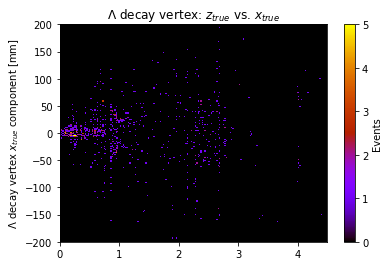

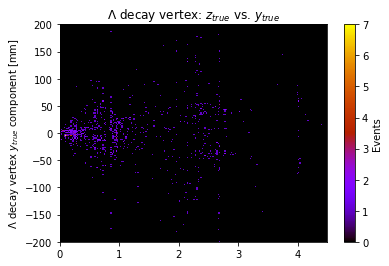

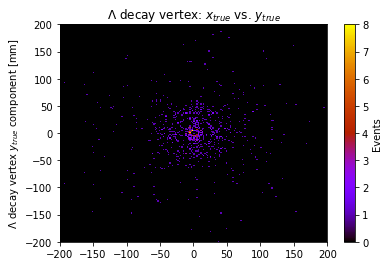

In [14]:
plt.hist2d(df_MC_Bump['MCTRUTH_L_ENDVERTEX_Z']/1000, df_MC_Bump['MCTRUTH_L_ENDVERTEX_X'],
           bins=200, cmap='gnuplot', range=[[0,4.5],[-200,200]])
plt.ylabel("$\Lambda$ decay vertex $z_{true}$ component [m]")
plt.ylabel("$\Lambda$ decay vertex $x_{true}$ component [mm]")
plt.title('$\Lambda$ decay vertex: $z_{true}$ vs. $x_{true}$')
plt.colorbar(label='Events')
plt.show()

plt.hist2d(df_MC_Bump['MCTRUTH_L_ENDVERTEX_Z']/1000, df_MC_Bump['MCTRUTH_L_ENDVERTEX_Y'],
           bins=200, cmap='gnuplot', range=[[0,4.5],[-200,200]])
plt.ylabel("$\Lambda$ decay vertex $z_{true}$ component [m]")
plt.ylabel("$\Lambda$ decay vertex $y_{true}$ component [mm]")
plt.title('$\Lambda$ decay vertex: $z_{true}$ vs. $y_{true}$')
plt.colorbar(label='Events')
plt.show()

plt.hist2d(df_MC_Bump['MCTRUTH_L_ENDVERTEX_X'], df_MC_Bump['MCTRUTH_L_ENDVERTEX_Y'],
           bins=200, cmap='gnuplot', range=[[-200,200],[-200,200]])
plt.ylabel("$\Lambda$ decay vertex $x_{true}$ component [mm]")
plt.ylabel("$\Lambda$ decay vertex $y_{true}$ component [mm]")
plt.title('$\Lambda$ decay vertex: $x_{true}$ vs. $y_{true}$')
plt.colorbar(label='Events')
plt.show()

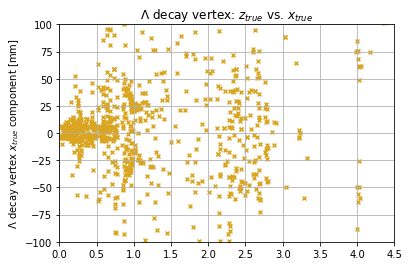

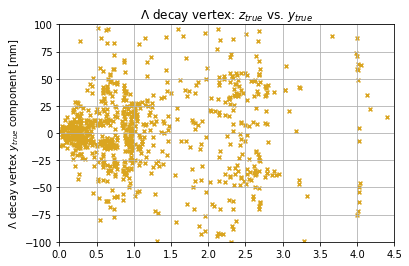

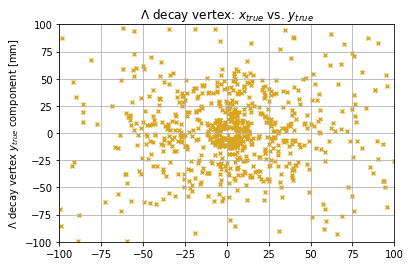

In [15]:
plt.scatter(df_MC_Bump['MCTRUTH_L_ENDVERTEX_Z']/1000, df_MC_Bump['MCTRUTH_L_ENDVERTEX_X'],
           marker='x', s=15, color='goldenrod')
plt.ylabel("$\Lambda$ decay vertex $z_{true}$ component [m]")
plt.ylabel("$\Lambda$ decay vertex $x_{true}$ component [mm]")
plt.title('$\Lambda$ decay vertex: $z_{true}$ vs. $x_{true}$')
plt.xlim((0,4.5))
plt.ylim((-100,100))
plt.grid()
plt.show()

plt.scatter(df_MC_Bump['MCTRUTH_L_ENDVERTEX_Z']/1000, df_MC_Bump['MCTRUTH_L_ENDVERTEX_Y'],
           marker='x', s=15, color='goldenrod')
plt.ylabel("$\Lambda$ decay vertex $z_{true}$ component [m]")
plt.ylabel("$\Lambda$ decay vertex $y_{true}$ component [mm]")
plt.title('$\Lambda$ decay vertex: $z_{true}$ vs. $y_{true}$')
plt.xlim((0,4.5))
plt.ylim((-100,100))
plt.grid()
plt.show()

plt.scatter(df_MC_Bump['MCTRUTH_L_ENDVERTEX_X'], df_MC_Bump['MCTRUTH_L_ENDVERTEX_Y'],
           marker='x', s=15, color='goldenrod')
plt.ylabel("$\Lambda$ decay vertex $x_{true}$ component [mm]")
plt.ylabel("$\Lambda$ decay vertex $y_{true}$ component [mm]")
plt.title('$\Lambda$ decay vertex: $x_{true}$ vs. $y_{true}$')
plt.xlim((-100,100))
plt.ylim((-100,100))
plt.grid()
plt.show()

## Miscellaneous checks

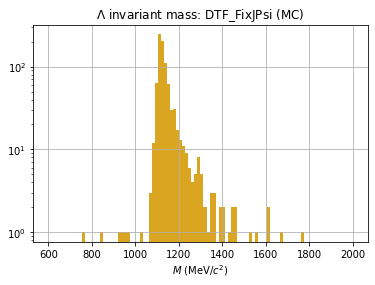

In [16]:
plt.hist(df_MC_Bump['DTF_FixJPsi_L_M'],bins=100,
         range=(600,2000), color='goldenrod', alpha=1, label="Pre-selection cuts", density=False)
plt.grid()
plt.yscale('log')
plt.xlabel("$M$ (MeV/$c^2$)")
plt.title("$\Lambda$ invariant mass: DTF_FixJPsi (MC)")
#plt.savefig("plots/lambda_invariant-mass/LIM_DTF-FixJPsi_MC.pdf", bbox_inches = "tight")
plt.show()

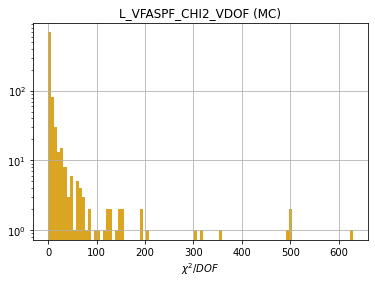

In [17]:
plt.hist(df_MC_Bump['L_VFASPF_CHI2_VDOF'], bins=100,
         color='goldenrod', label="Pre-selection cuts", alpha=1)
plt.yscale('log')
plt.grid()
plt.title("L_VFASPF_CHI2_VDOF (MC)")
plt.xlabel("$\chi^2 / DOF$")
#plt.savefig("plots/lambda_vertex-fit/LVF_VFASPF_CHI2_VDOF_MC.pdf", bbox_inches = "tight")
plt.show()